In [2]:
cd ..

f:\CodingEnvironment\DPDPTW2F


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [23]:
import json
import matplotlib.pyplot as plt
from moo_algorithm.metric import cal_hv  # <-- adjust import as needed
import numpy as np

def read_json(filename):
    """
    Utility function to read JSON data from file.
    """
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def calculate_hv_over_generations(algorithm_data, ref_point):
    """
    Given the data for one algorithm (e.g., "NSGA-II"),
    compute hypervolume for each generation.
    
    The structure is:
    {
      "0": [
        [0.7426, 0.1261, 0.3681],
        ...
      ],
      "1": [
        [0.7488, 0.1250, 0.3417],
        ...
      ],
      ...
    }
    """
    hv_values = []
    
    # Convert the generation keys to integers and sort them 
    # to get generations in ascending order.

    # gen_indices = sorted(int(g) for g in algorithm_data.keys()[:-2])
    
    for gen_idx in range(101):
        str_idx = str(gen_idx)                   # Convert back to string for dictionary access
        front = algorithm_data[str_idx]          # front is a list of objective vectors
        hv = cal_hv(np.array(front), ref_point)     # compute the hypervolume for this generation
        hv_values.append(hv)
        
    return hv_values

def plot_convergence_trend(hv_values_nsga2, hv_values_pfg):
    """
    Plot HV vs. generation for NSGA-II and PFG-EMOA (example).
    """
    # We'll assume both have the same number of generations for demonstration
    # If not, you can handle them separately or adapt the code.
    generations = range(1, len(hv_values_nsga2) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(generations, hv_values_nsga2, label='NSGA-II', marker='o')
    plt.plot(generations, hv_values_pfg, label='PFG-EMOA', marker='s')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume')
    plt.title('Convergence Trend')
    plt.legend()
    plt.grid(True)
    plt.show()

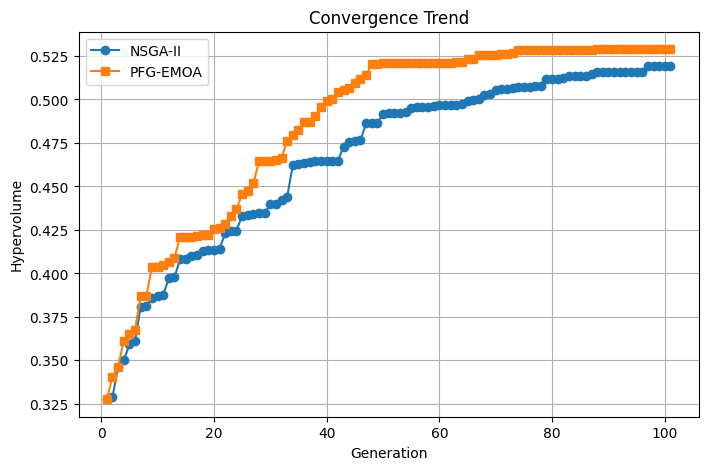

In [24]:

# 1) Read the JSON results
results = read_json("Result/LC2_8_1_0.json")  # Adjust path as needed

# 2) Choose a reference point that is "worse" than any point in the data
reference_point = [1.0, 1.0, 1.0]  # Example for a 3-objective problem; adjust as needed

# 3) Extract data for each algorithm
#    Suppose your JSON has two top-level keys: "NSGA-II" and "PFG-EMOA"
nsga2_data = results["NSGA-II"]         # e.g. { "0": [[...],[...]], "1": [[...],[...]], ... }
pfg_data   = results["PFG-EMOA"]        # e.g. { "0": [[...],[...]], "1": [[...],[...]], ... }

# 4) Compute HV for each generation
hv_values_nsga2 = calculate_hv_over_generations(nsga2_data, reference_point)
hv_values_pfg   = calculate_hv_over_generations(pfg_data, reference_point)

# 5) Plot the convergence trend
plot_convergence_trend(hv_values_nsga2, hv_values_pfg)

In [1]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV

def cal_hv(front, ref_point):
    with np.errstate(divide='ignore', invalid='ignore'):
        scaled_front = np.divide(front, ref_point, out=np.zeros_like(front), where=ref_point!=0)
    scaled_ref_point = np.ones_like(ref_point)
    hv_indicator = HV(ref_point=scaled_ref_point)
    return hv_indicator(scaled_front)

# Settings
base_path = "F:/setup files/downloads/Result1/"
nadir_csv_path = os.path.join(base_path, "nadir_points.csv")

# Load the nadir points CSV
nadir_df = pd.read_csv(nadir_csv_path)

# Types and corresponding patterns
problem_types = [200, 400, 800]
generation_steps = range(100, 1001, 100)  # Adjust based on available generations

# Create a plot for each problem type
for prob_type in problem_types:
    # Use glob to find all JSON files matching the problem type pattern.
    # Assuming file pattern like "{type}_*_*_0.json"
    file_pattern = os.path.join(base_path, f"{prob_type}_*_*_0.json")
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found for problem type {prob_type}.")
        continue

    # Initialize dictionary to store HV trends: {algorithm: {generation: [HV values across files]}}
    hv_trends = {}

    # Process each file for the given problem type
    for file_path in files:
        file_name = os.path.basename(file_path)

        # Find the corresponding nadir row using file_name
        nadir_row = nadir_df[nadir_df['file'] == file_name]
        if nadir_row.empty:
            print(f"Nadir info not found for {file_name}. Skipping.")
            continue
        nadir_row = nadir_row.iloc[0]

        # Extract the nadir point for scaling
        obj_columns = sorted(
            [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
            key=lambda x: int(x.split('_')[1])
        )
        nadir_point = np.array([nadir_row[col] for col in obj_columns])

        # Load JSON data
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Iterate over each algorithm in the JSON data
        for algorithm in data:
            # Initialize hv_trends structure for the algorithm if not exists
            if algorithm not in hv_trends:
                hv_trends[algorithm] = {gen: [] for gen in generation_steps}

            # Loop through the designated generations
            for gen in generation_steps:
                gen_key = str(gen)
                if gen_key not in data[algorithm]:
                    # If a specific generation is missing, skip
                    continue
                solutions = data[algorithm][gen_key]
                solutions_np = np.array(solutions)

                if solutions_np.size == 0:
                    continue

                try:
                    hv_value = cal_hv(solutions_np, nadir_point)
                except Exception as e:
                    print(f"Error computing HV for {algorithm} in generation {gen} of {file_name}: {e}")
                    continue

                hv_trends[algorithm][gen].append(hv_value)

    # Compute average HV per generation for each algorithm across files
    avg_hv_trends = {}
    for algorithm, gen_dict in hv_trends.items():
        avg_hv_trends[algorithm] = {
            gen: np.mean(hv_list) if hv_list else np.nan 
            for gen, hv_list in gen_dict.items()
        }

    # Plot the HV convergence for each algorithm
    plt.figure(figsize=(10, 6))
    for algorithm, gen_data in avg_hv_trends.items():
        generations = sorted(gen_data.keys())
        hv_values = [gen_data[gen] for gen in generations]
        plt.plot(generations, hv_values, marker='o', label=algorithm)

    plt.title(f'HV Convergence Trend for Problem Type {prob_type}')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume (HV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save or show plot
    plot_filename = os.path.join(base_path, f"HV_Convergence_Type_{prob_type}.png")
    plt.savefig(plot_filename)
    plt.show()
    print(f"Plot saved to {plot_filename}")


No files found for problem type 200.
No files found for problem type 400.
No files found for problem type 800.
